In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

%matplotlib inline

from tqdm.notebook import trange




2024-01-22 19:50:17.716487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 19:50:17.716526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 19:50:17.717747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 19:50:17.723714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 19:50:18.435560: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
def load_data():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # change the parameters from a range of -1 to +1
    train_images = (train_images.astype(np.float32) - 127.5) / 127.5

    # convert shape of train_images from (60000, 28, 28) to (60000, 784)
    train_images = train_images.reshape(-1, 28*28)
 
    return (train_images, train_labels, test_images, test_labels) 




In [4]:
(train_images, train_labels, test_images, test_labels) = load_data()

print(train_images.shape)

(60000, 784)


In [5]:
def custom_adam_optimizer():
    # beta_1 = 0.65 => indica che ci portiamo solo il 65% dei parametri della backpropagation
    return Adam(learning_rate=0.00005, beta_1=0.65)

In [6]:
# Create Generator
def create_generator():
    generator = Sequential(name="Generator")
    #diamo in pasto 100 parametri
    generator.add(Dense(units=256, input_dim=100, activation='relu'))
    generator.add(Dense(units=512, activation='relu'))
    generator.add(Dense(units=1024, activation='relu'))
    # generiamo un output uguale a quello del dataset di default e con la funzione tanh verifichiamo parametri tra -1 e 1
    generator.add(Dense(units=784, activation='tanh'))

    # la valutazione dell'immagine generata e' binaria, 0 errata, 1 corretta (per questo utilizziamo binary_crossentropy)
    generator.compile(loss='binary_crossentropy', optimizer=custom_adam_optimizer())

    return generator

g = create_generator()
g.summary()

print(f"Type: {type(g)}")

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 784)               803600    
                                                                 
Total params: 1486352 (5.67 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Type: <class 'keras.src.engine.sequential.Sequential'>


2024-01-22 19:50:19.494774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 19:50:19.552265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 19:50:19.552529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# Create Discriminator
def create_discriminator():
    discriminator = Sequential(name="Discriminator")
    #diamo in pasto 100 parametri
    discriminator.add(Dense(units=1024, input_dim=784, activation='relu'))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units=512, activation='relu'))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units=256, activation='relu'))

    discriminator.add(Dense(units=1, activation='sigmoid'))


    # la valutazione dell'immagine generata e' binaria, 0 errata, 1 corretta (per questo utilizziamo binary_crossentropy)
    discriminator.compile(loss='binary_crossentropy', optimizer=custom_adam_optimizer())

    return discriminator

d = create_discriminator()
d.summary()

print(f"Type: {type(d)}")

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1460225 (5.57 MB)
Trainable params: 146

In [8]:
# Create the GAN

def create_gan(generator: Sequential, discriminator: Sequential):
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    x = generator(gan_input)

    gan_ouput = discriminator(x)

    gan = Model(inputs=[gan_input], outputs=[gan_ouput])
    gan.compile(loss='binary_crossentropy', optimizer=custom_adam_optimizer())

    return gan


gan = create_gan(g,d)
gan.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 Generator (Sequential)      (None, 784)               1486352   
                                                                 
 Discriminator (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 2946577 (11.24 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


In [9]:
# preview images
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), fig_size=(10,10)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])

    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100, 28, 28)

    plt.figure(figsize=fig_size)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"data/gan/gan_generated_image{epoch}.png")

In [10]:
# contatore epoche di addestramento
# utile per il log durante il training
epoche_addestramento = 0

In [11]:
def training(epochs, batch_size, epoche_addestramento):
    # carico il dataset
    (train_images, train_labels, test_images, test_labels) = load_data()

    # creazione del modello
    generator = create_generator()
    discriminator = create_discriminator()

    gan = create_gan(generator, discriminator)

    tot_epoche = epoche_addestramento + epochs

    for epoca in range(1, epochs + 1):
        losses = 0
        epoca_attuale = epoca + epoche_addestramento

        # print(f"epoca attuale: {epoca_attuale}")

        t = trange(batch_size, desc='', leave=True)
        for batch in t:
            msg = f"Epoca {str(epoca_attuale)}/{str(tot_epoche)} - Batch {str(batch + 1)}/{str(batch_size)} - Loss {str(losses/(batch + 1))[:6]} "
            t.set_description(msg)
            t.refresh()

            # generazione del distrurbo come input per il generatore
            noise = np.random.normal(0,1, [batch_size, 100]) 

            # generazione di immagini fake del MNIST
            generated_images = generator.predict(noise)

            # recupero un subset casuale di immagini da MNIST
            image_batch = train_images[np.random.randint(low=0, high=train_images.shape[0], size=batch_size)]

            # costruzione del batch di immagini reali e generate
            X = np.concatenate([image_batch, generated_images])

            # generare anche le etichette per queste immagini
            # la prima parte (proveniente dal dataset originale) saranno con valore 0
            # la seconda parte, quelle generate avrenno un valore vicino all'uno (0.9) per far si che il discriminatore non sia cosi "cattivo"
            y_dis = np.zeros(2 * batch_size) # ho il "doppio delle immagini nel dataset che valuto"
            y_dis[:batch_size] = 0.9 # assegno il valore di 0.9

            # eseguo il training del discriminatore su immagini reali e generate
            # prima dell'addestramento della GAN
            discriminator.trainable = True
            losses += discriminator.train_on_batch(X, y_dis)

            # creazione di un dataset utile al generatore
            noise = np.random.normal(0, 1, [batch_size, 100])
            y_gen = np.ones(batch_size)


            discriminator.trainable = False

            # addestramento della GAN 
            # generatore che si addestra ad "ingannare" il discriminatore
            gan.train_on_batch(noise, y_gen)

        # ogni tot epoche vengono create delle immagini per visualizzare i file generati dal generatore 
        if epoca_attuale == 1 or epoca_attuale == 5 or epoca_attuale == 10 or epoca_attuale % 20 == 0:
            plot_generated_images(epoca, generator)

    return epoche_addestramento + epochs







  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


2024-01-22 19:50:21.564630: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f15581c6af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-22 19:50:21.564658: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-22 19:50:21.569145: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-22 19:50:21.598915: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1705949421.668804   63920 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 0s 3ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 963us/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 968us/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 1ms/step


KeyboardInterrupt: 

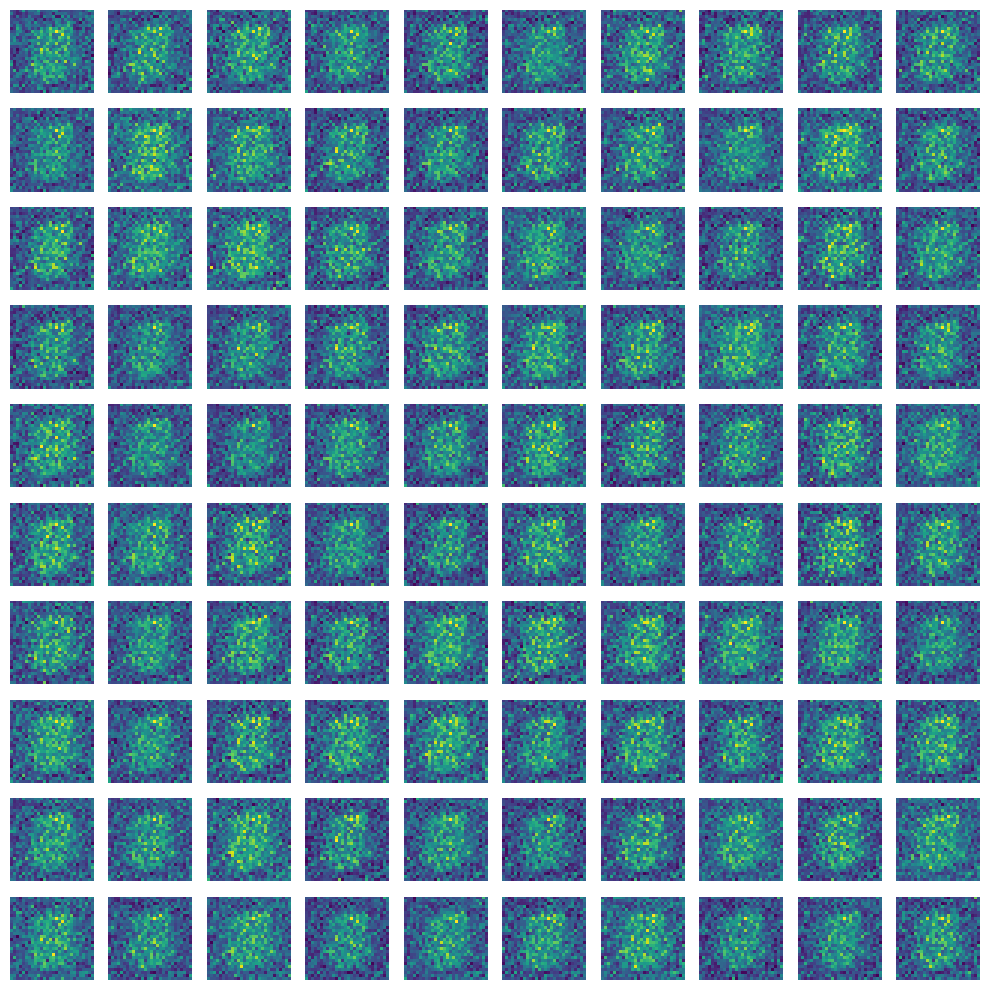

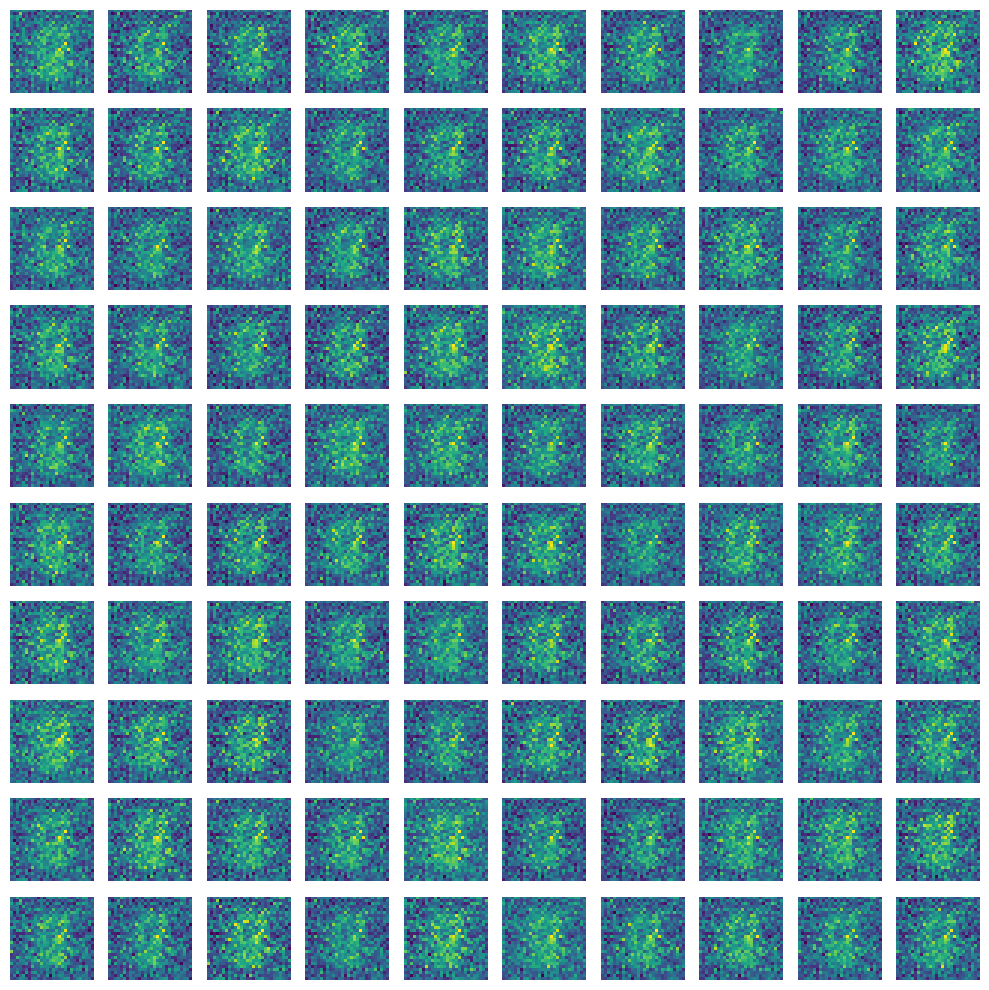

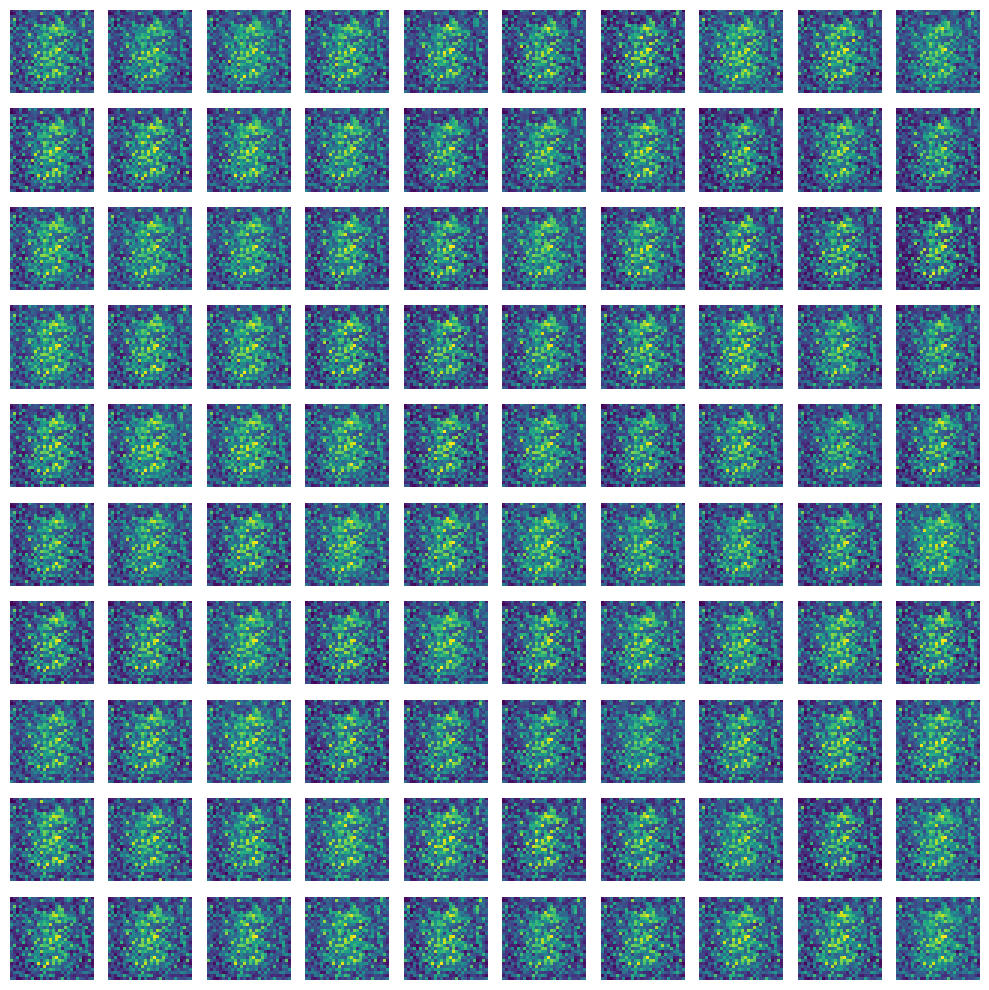

In [12]:
from datetime import datetime

start  = datetime.now()  

epoche = 400

epoche_addestramento = training(epochs=epoche, batch_size=128, epoche_addestramento=epoche_addestramento)

end = datetime.now()  

execution_time = end - start
execution_time_in_s = execution_time.total_seconds() 

print(f"tempo: {execution_time_in_s}")

